
Model Performance (CatBoost without optimization):
MSE: 0.00032218430207791313
R²: 0.995995781840431


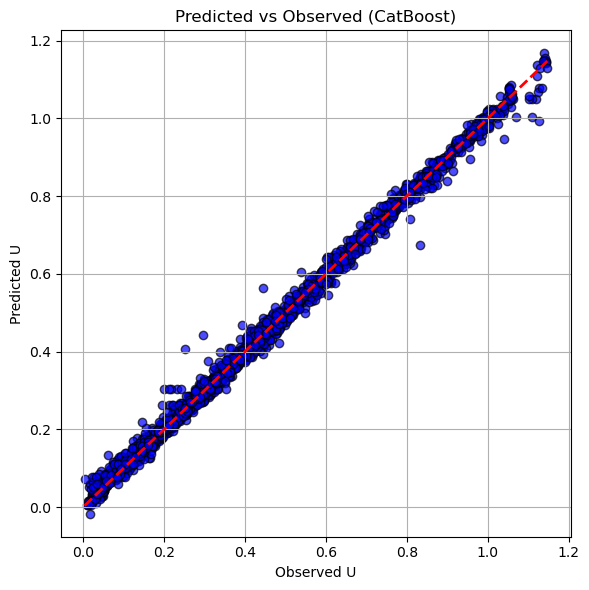

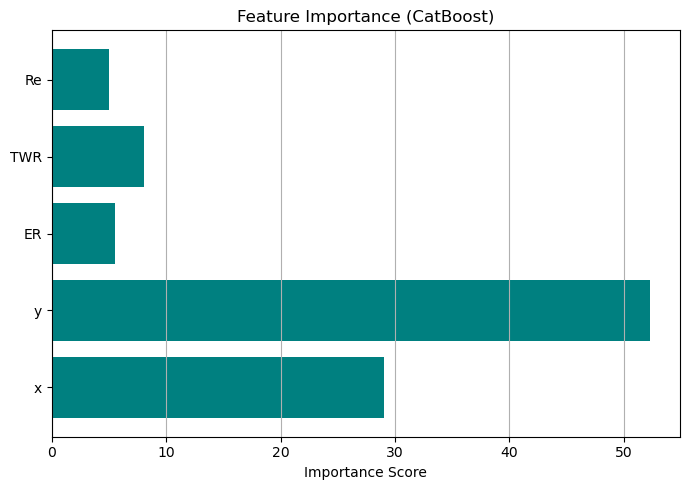

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor, Pool
from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args

# -------------------------
# Load Data
# -------------------------
data = pd.read_csv("Udata.csv")
X = data.iloc[:, 0:5].values   # Features
y = data.iloc[:, 5].values     # Label

# Split data (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# -------------------------
# Define Search Space for Bayesian Optimization
# -------------------------
space  = [
    Integer(3, 10, name="depth"),                # Tree depth
    Real(0.01, 0.3, prior="log-uniform", name="learning_rate"), # Learning rate
    Real(1, 10, prior="log-uniform", name="l2_leaf_reg")        # L2 regularization
]

# -------------------------
# Objective Function
# -------------------------
@use_named_args(space)
def objective(**params):
    model = CatBoostRegressor(
        depth=params["depth"],
        learning_rate=params["learning_rate"],
        l2_leaf_reg=params["l2_leaf_reg"],
        iterations=300,
        silent=True,
        random_seed=42
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_squared_error(y_test, preds)   # minimize MSE

# -------------------------
# Run Bayesian Optimization
# -------------------------
res = gp_minimize(objective, space, n_calls=20, random_state=42, n_initial_points=5)

best_depth = res.x[0]
best_lr = res.x[1]
best_l2 = res.x[2]

print("\nBest Parameters Found by Bayesian Optimization:")
print(f"Depth: {best_depth}, Learning Rate: {best_lr:.4f}, L2 Leaf Reg: {best_l2:.4f}")
print("Best MSE:", res.fun)

# -------------------------
# Train Final Model with Best Parameters
# -------------------------
final_model = CatBoostRegressor(
    depth=best_depth,
    learning_rate=best_lr,
    l2_leaf_reg=best_l2,
    iterations=500,
    silent=True,
    random_seed=42
)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nFinal Model Performance:")
print("MSE:", mse)
print("R²:", r2)

# -------------------------
# Plot 1: Predicted vs. Observed
# -------------------------
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, c='blue', alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel("Observed U")
plt.ylabel("Predicted U")
plt.title("Predicted vs Observed (CatBoost + Bayesian Optimization)")
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------
# Plot 2: Feature Importance
# -------------------------
feature_names = data.columns[0:5]
importances = final_model.get_feature_importance(Pool(X_train, y_train))

plt.figure(figsize=(7, 5))
plt.barh(feature_names, importances, color="teal")
plt.xlabel("Importance Score")
plt.title("Feature Importance (CatBoost + Bayesian Optimization)")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

# -------------------------
# Plot 3: Convergence of BO
# -------------------------
plt.figure(figsize=(7,5))
plt.plot(res.func_vals, marker="o", c="purple")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.title("Bayesian Optimization Convergence")
plt.grid(True)
plt.tight_layout()
plt.show()
